## <center> Hansard Data HOC</center>

In [14]:
%matplotlib inline

import operator
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from functools import reduce
import warnings
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning)
filterwarnings(action='ignore', category=FutureWarning)

from utils.utils import *

import import_ipynb
import text_exploration as te
import lda_topic_modelling as lda
import co_occurrence_network as cn
import custom_topic_modelling as ctm
import w2v_ortho_prosecutes as w2vop
import semantic_similarity as ss

In [11]:
from PIL import Image
from wordcloud import WordCloud

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim

# spaCy for Lemmatization
import spacy

plt.rcParams['figure.figsize'] = 12, 8

In [12]:
data_2021 = './data/hansard-speeches-processed-post2021.pkl'
data_2020 = './data/hansard-speeches-processed-post2020.pkl'

PATH = "./models/Cr5-master"
BASE_PATH = "./assets/images/"

# Load the pickle file
df_2021 = load_pickle_file(data_2021)
df_2020 = load_pickle_file(data_2020)

# Aggregrating the speech datewise and major heading
df_head_dt_gp_21 = aggregate_speeches(df_2021)
df_head_dt_gp_20 = aggregate_speeches(df_2020)

df_ireland_21 = get_speech_by_heading(df_head_dt_gp_21, 'Northern Ireland')
df_ireland_20 = get_speech_by_heading(df_head_dt_gp_20, 'Northern Ireland')

df_covid_21 = get_speech_by_heading(df_head_dt_gp_21, 'Covid-19 Update')
df_covid_20 = get_speech_by_heading(df_head_dt_gp_20, 'Covid-19 Update')

df_pm_21 = get_speech_by_heading(df_head_dt_gp_21, 'Prime Minister')
df_pm_20 = get_speech_by_heading(df_head_dt_gp_20, 'Prime Minister')

#### Exploring Hansard Data
+ We will explore the text in the hansard data for the time range of 2021 and 2020

In [4]:
df_head_dt_gp_21['major_heading'].value_counts()[:10]

Business of the House                  44
Point of Order                         43
Prime Minister                         37
Speaker’s Statement                    32
Points of Order                        30
Delegated Legislation                  24
Covid-19 Update                        24
Royal Assent                           14
Covid-19                               11
United Kingdom Internal Market Bill    10
Name: major_heading, dtype: int64

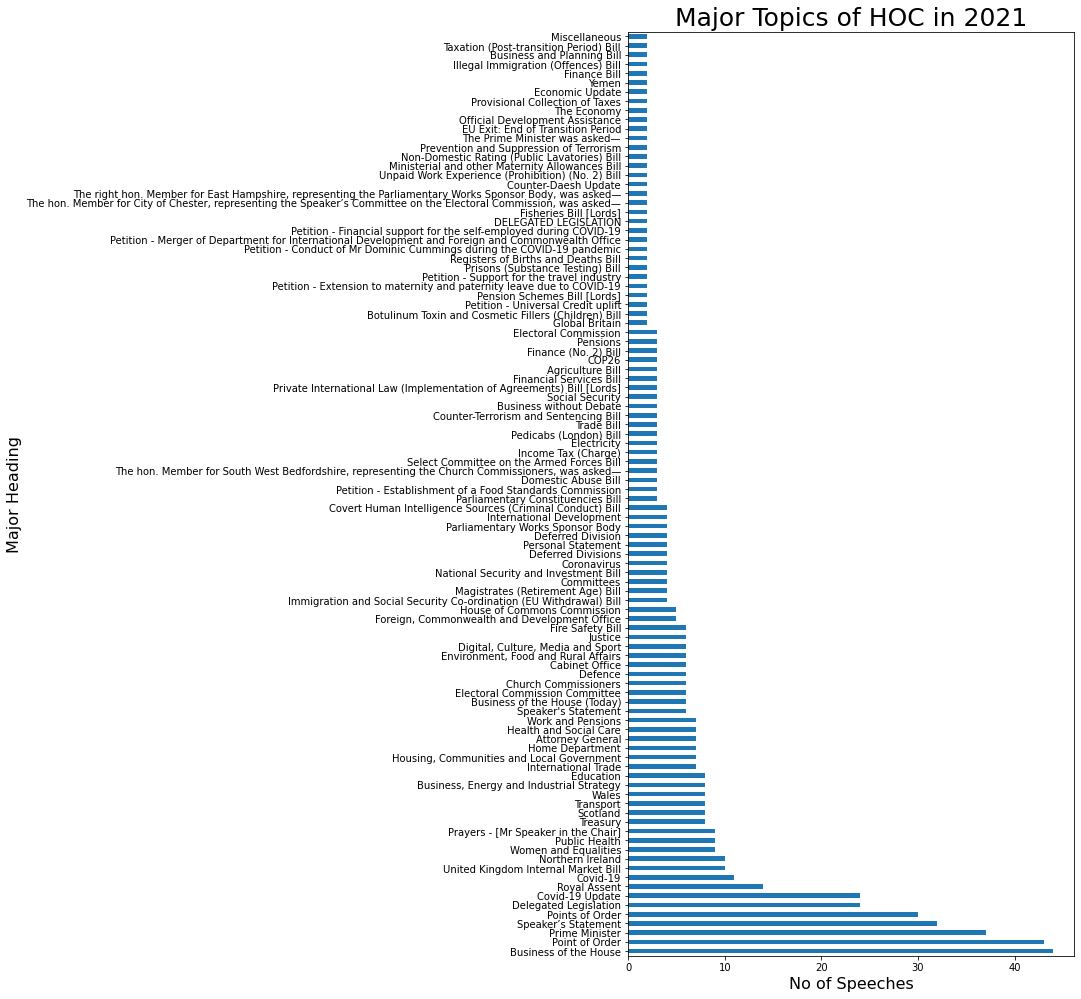

In [5]:
## Topics discussed in House of Commons
hoc_data = te.HOCDataExploration(df_head_dt_gp_21, df_head_dt_gp_20)
hoc_data.get_topics_plot(df_head_dt_gp_21, "hoc_topics")

No of speeches: 10


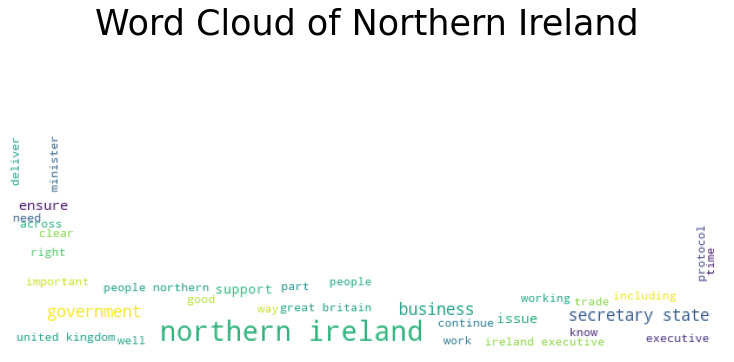

In [6]:
print(f"No of speeches: {df_ireland_21.shape[0]}")

# Plotting wordcloud for topic
parliament_data = hoc_data.wordcloud_data(df_ireland_21)
hoc_data.plot_word_cloud(parliament_data, "Northern Ireland")

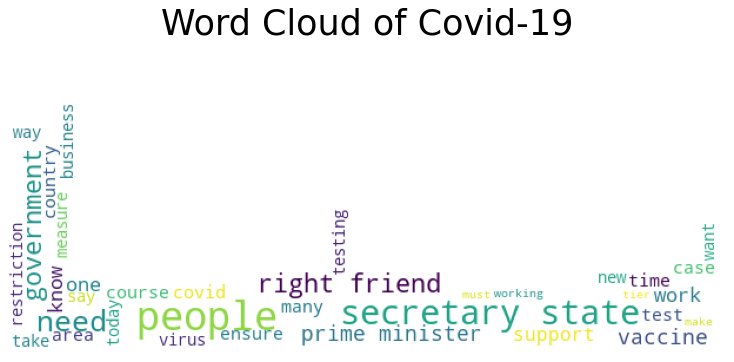

In [7]:
parliament_data = hoc_data.wordcloud_data(df_covid_21)
hoc_data.plot_word_cloud(parliament_data, "Covid-19")

#### LDA Topic Modelling
+ We will perform the topic modelling of hansard data using Latent Dirichlet Allocation algorithm

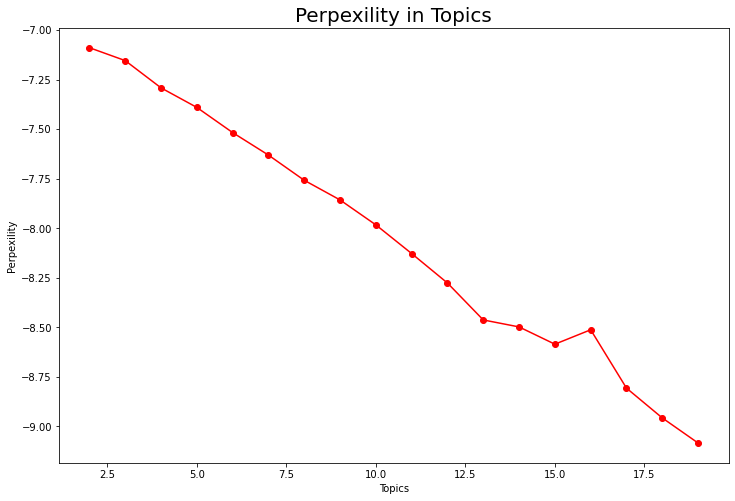

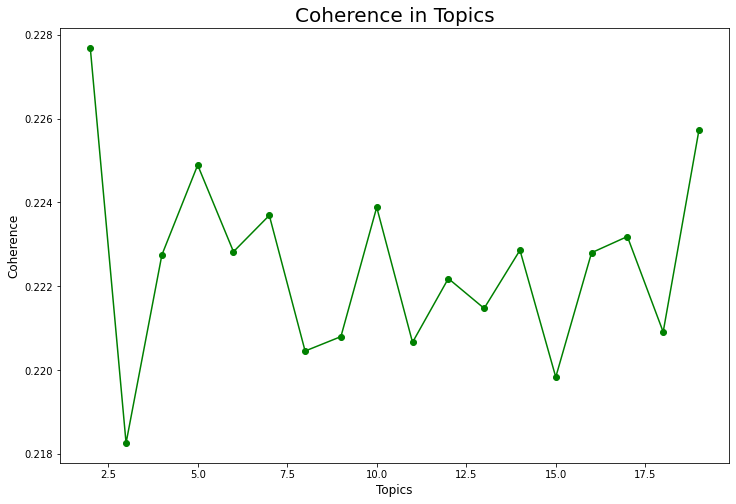

In [13]:
lda_topic = lda.HOCLDATopic(df_head_dt_gp_21)

# Topics
topics = 10

# Creating data for LDA
id2word, corpus, data_lemmatized = lda_topic.get_lda_data(df_ireland_21)
# LDA model
lda_model = lda_topic.get_lda_model(id2word, corpus, topics)

### Testing LDA model
# Perplexity and Cohesion for LDA Metric
perplexity, cohesion = lda_topic.test_lda_model(corpus, id2word, lda_model, data_lemmatized)
lda_topic.plot_lda_test(perplexity, cohesion)


Looking at the Perplexity and Cohesion graphs, we will take 6 topics in our data

In [15]:
### Changing the topics to 6
topics = 6
# LDA model
lda_model = lda_topic.get_lda_model(id2word, corpus, topics)
# Print the Keyword in the topics
pprint(lda_model.print_topics())

[(0,
  '0.011*"government" + 0.010*"make" + 0.009*"support" + 0.009*"work" + '
  '0.009*"issue" + 0.009*"ensure" + 0.008*"good" + 0.008*"right" + '
  '0.007*"take" + 0.007*"continue"'),
 (1,
  '0.011*"government" + 0.010*"work" + 0.008*"support" + 0.007*"ensure" + '
  '0.007*"make" + 0.007*"people" + 0.007*"business" + 0.006*"right" + '
  '0.006*"issue" + 0.006*"northern"'),
 (2,
  '0.012*"work" + 0.011*"people" + 0.010*"business" + 0.009*"government" + '
  '0.009*"make" + 0.008*"good" + 0.007*"support" + 0.007*"ensure" + '
  '0.007*"right" + 0.007*"northern"'),
 (3,
  '0.015*"work" + 0.013*"make" + 0.010*"government" + 0.010*"people" + '
  '0.009*"ensure" + 0.008*"business" + 0.008*"good" + 0.007*"continue" + '
  '0.007*"support" + 0.007*"take"'),
 (4,
  '0.013*"work" + 0.010*"people" + 0.010*"government" + 0.009*"make" + '
  '0.008*"support" + 0.008*"good" + 0.008*"business" + 0.007*"right" + '
  '0.007*"state" + 0.007*"take"'),
 (5,
  '0.014*"government" + 0.012*"work" + 0.012*"busi

In [7]:
# Comparing all of them - all text
pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(visualization, BASE_PATH+'lda.html')
visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.004567  0.001124       1        1  52.837746
4      0.002198 -0.004317       2        1  28.017115
3      0.000869  0.002051       3        1  13.508867
2      0.000034  0.001440       4        1   5.083963
5     -0.006388 -0.000420       5        1   0.399099
1     -0.001280  0.000122       6        1   0.153210, topic_info=           Term        Freq       Total Category  logprob  loglift
662        work  246.000000  246.000000  Default  30.0000  30.0000
266  government  266.000000  266.000000  Default  29.0000  29.0000
353        make  199.000000  199.000000  Default  28.0000  28.0000
580     support  187.000000  187.000000  Default  27.0000  27.0000
68     business  208.000000  208.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
567       state    0.156405  113.590814   Topic6  -5.3004  -0.1068
266  government    0.275595  266.518541   Topic6  -4.7339  -0.3932
416      people    0.213442  185.287321   Topic6  -4.9895  -0.2852
298   important    0.120991   81.051954   Topic6  -5.5571  -0.0260
380        need    0.115159   92.791351   Topic6  -5.6065  -0.2107

[526 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.546590        able
0         2  0.255075        able
0         3  0.145757        able
0         4  0.072879        able
3         1  0.541118  absolutely
...     ...       ...         ...
662       5  0.004057        work
667       1  0.509743        year
667       2  0.275537        year
667       3  0.151545        year
667       4  0.055107        year

[864 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 6, 2])

#### Co-Occurence Network
+ We will make the co-occurrence network of the Hansard data

No of nodes 2593
No of edges 14467


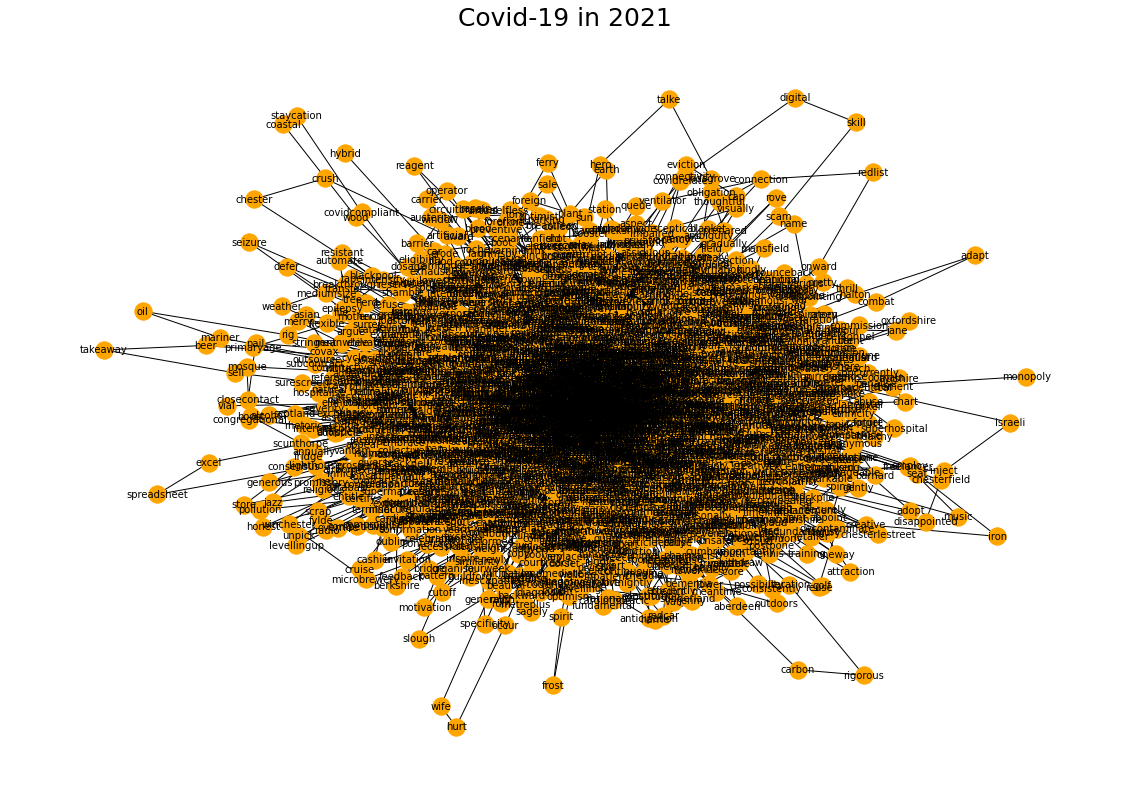

In [4]:
# Getting the corpus and lemmatized data
lda_topic = lda.HOCLDATopic(df_head_dt_gp_21)
id2word, corpus, data_lemmatized_21 = lda_topic.get_lda_data(df_covid_21)

# # Reducing the network to select the words greater than 1 times in a document
network = cn.HOCNetwork()
G_21 =  network.get_reduced_network(data_lemmatized_21)
# Plotting the co-occurence network of Covid-19 in 2021
network.plot_co_occurence_network(G_21, "Covid-19 in 2021")

No of nodes 436
No of edges 435


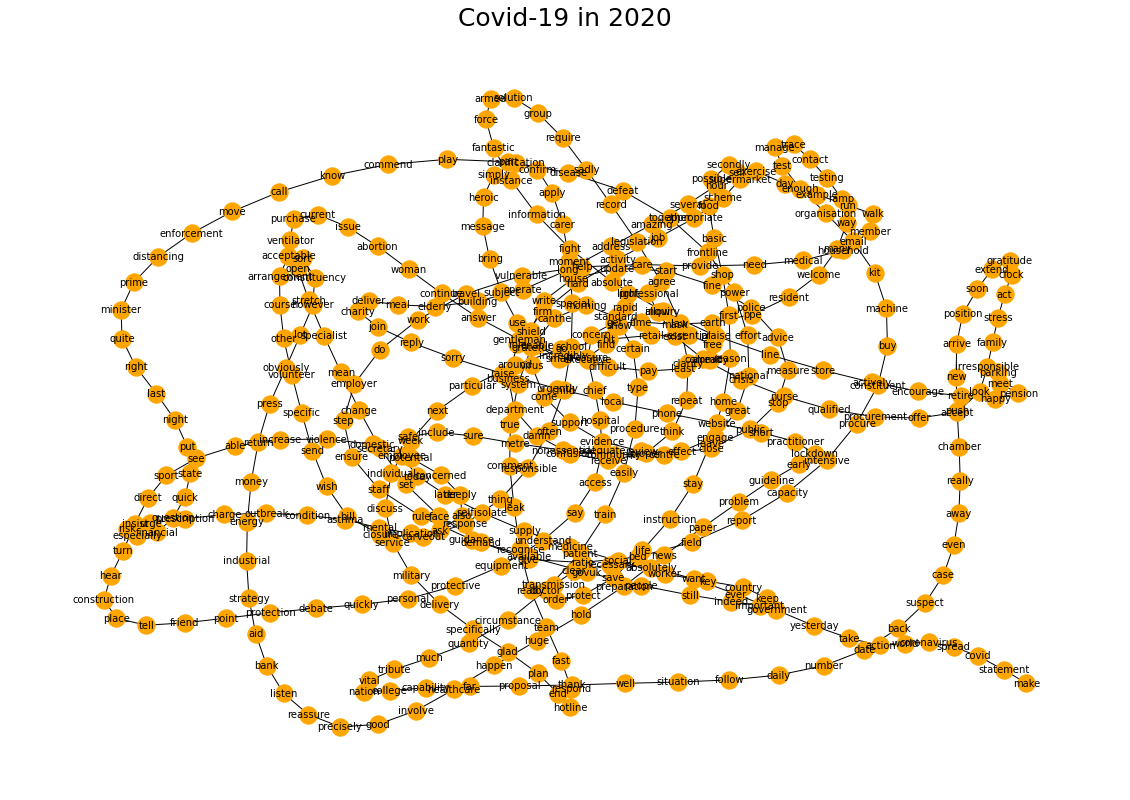

In [5]:
id2word, corpus, data_lemmatized_20 = lda_topic.get_lda_data(df_covid_20)

G_20 =  network.get_reduced_network(data_lemmatized_20)
# Plotting the co-occurence network of Covid-19 in 2020
network.plot_co_occurence_network(G_20, "Covid-19 in 2020")

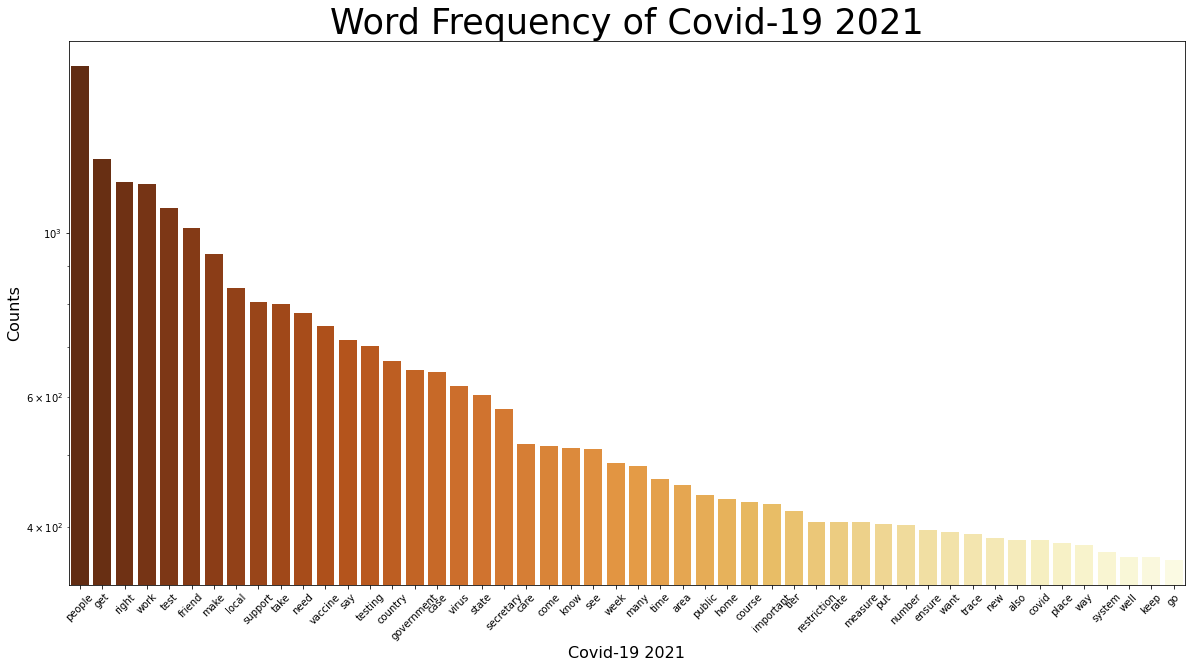

In [6]:
## Creating FreqDist - Focus on the 50 most common tokens in Covid-19 in 2021
n = 50
flatten_words = reduce(operator.concat, data_lemmatized_21)
network.get_word_frequency(flatten_words, n ,"Covid-19 2021")

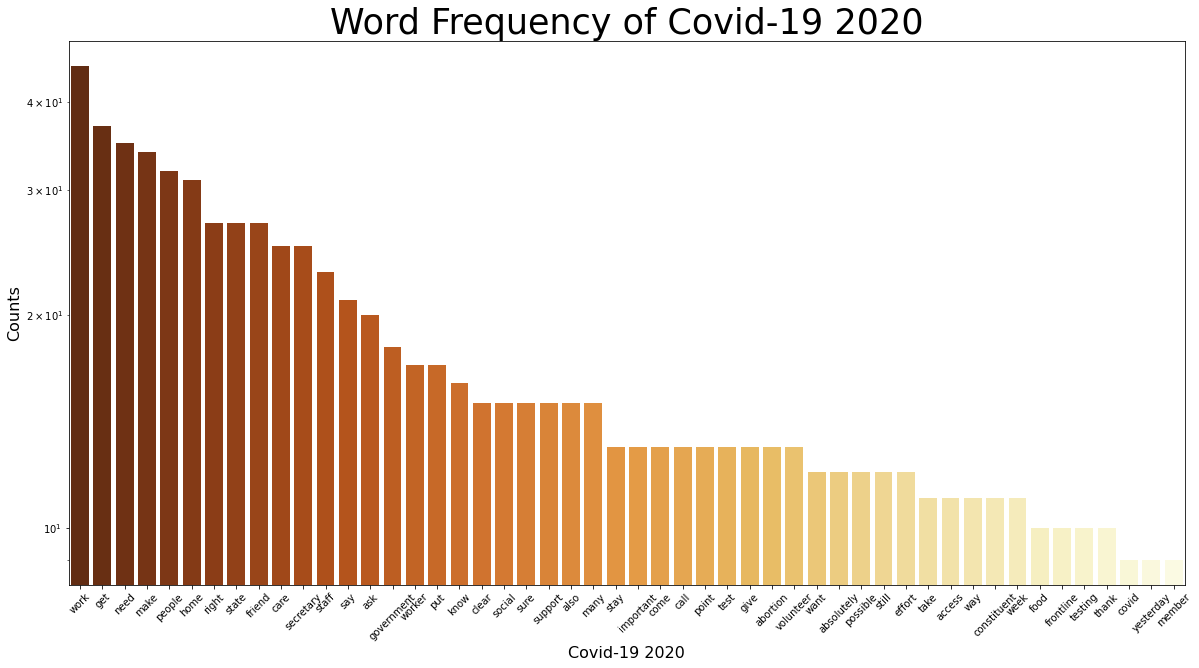

In [7]:
## Creating FreqDist - Focus on the 50 most common tokens in Covid-19 in 2020
flatten_words = reduce(operator.concat, data_lemmatized_20)
network.get_word_frequency(flatten_words, n ,"Covid-19 2020")

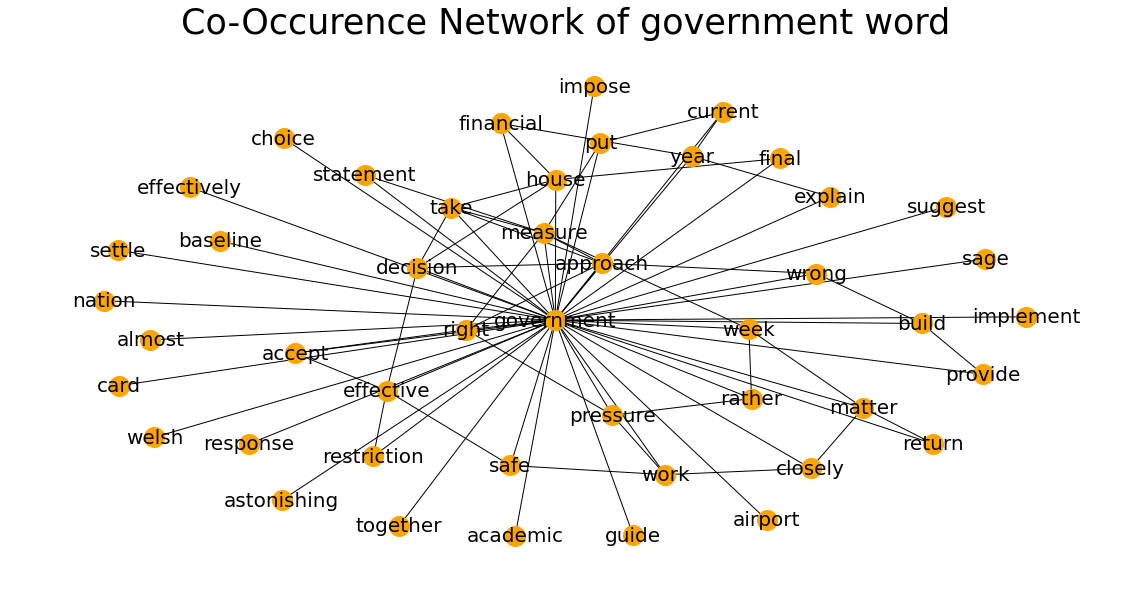

In [18]:
word = "government"
# Fetch the neighbouring words of government  in 2021
government_21 = network.get_neighbouring_words(word, G_21)
# Plot the neighbouring words of government in 2021
network.plot_neighbhour_words(word, G_21, government_21)

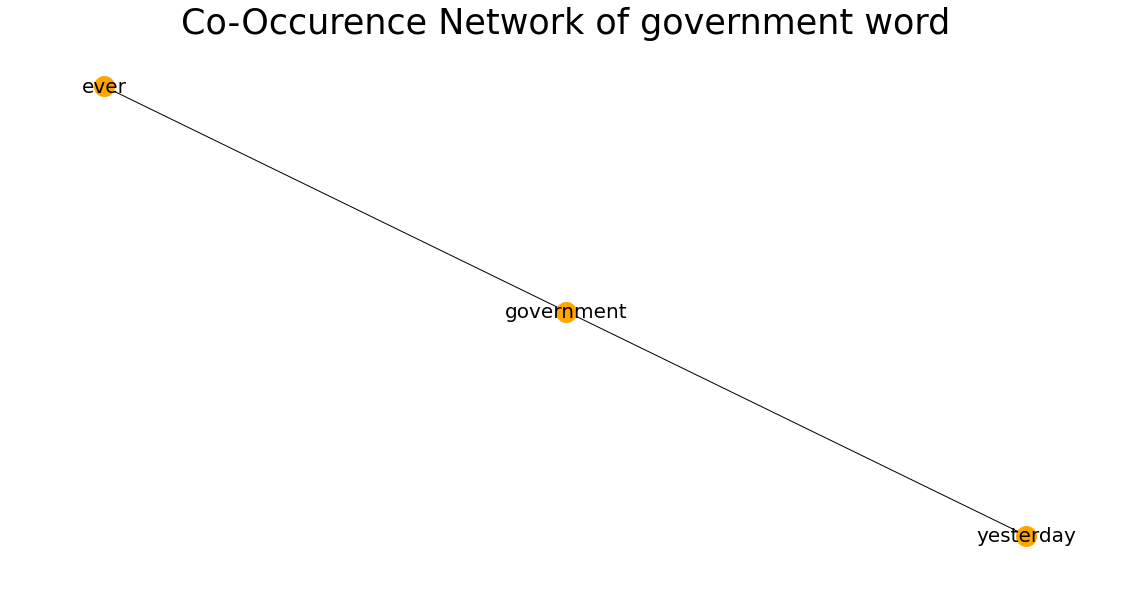

In [9]:
word = "government"
# Fetch the neighbouring words of government  in 2020
government_20 = network.get_neighbouring_words(word, G_20)
# Plot the neighbouring words of government in 2020
network.plot_neighbhour_words(word, G_20, government_20)

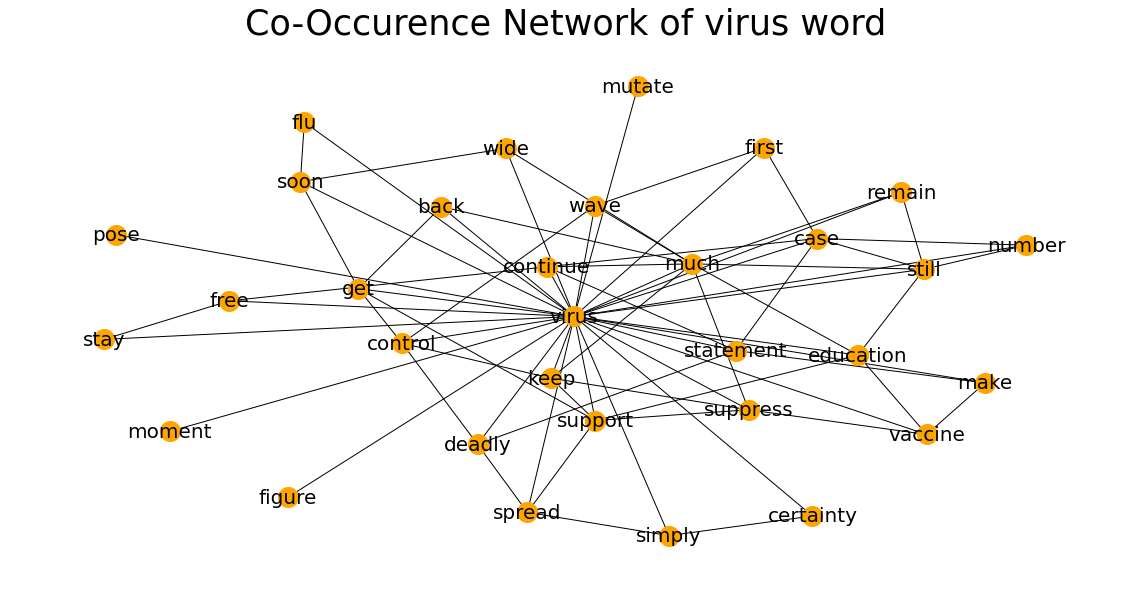

In [19]:
word="virus"
# Fetch the neighbouring words of virus in 2021
virus_21 = network.get_neighbouring_words(word, G_21)
# Plot the neighbouring words of virus in 2021
network.plot_neighbhour_words(word, G_21, virus_21)

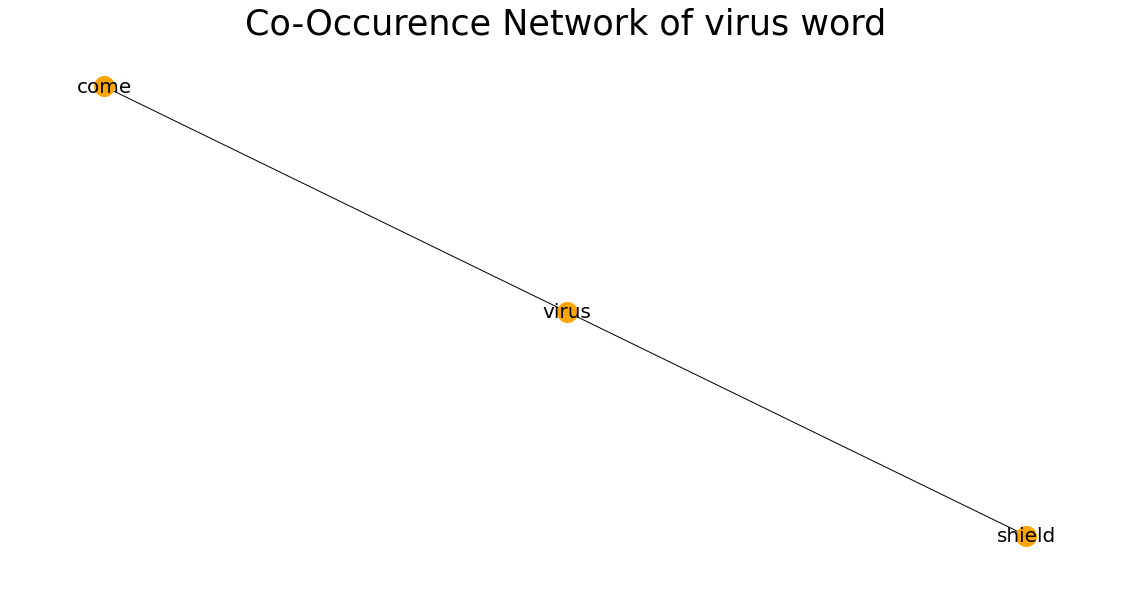

In [11]:
word = "virus"
# Fetch the neighbouring words of virus in 2020
virus_20 = network.get_neighbouring_words(word, G_20)
# Plot the neighbouring words of virus in 2020
network.plot_neighbhour_words(word, G_20, virus_20)

##### Semantic Similarity
+ We will check the semantic similarity in the word vector by counting the similar words in the both the year within the co-occurence network

In [12]:
# Similarity score of government network in two different span of years
score = network.check_similarity(government_20, government_21)
print(f'{score:.2f}%')

33.33%


#### Custom Topic Modelling
We will do the custom topic modelling based on below methods
+ Document embedding via Cr5 model
+ UMAP for dimensionality reduction
+ KMeans/ HDBSCAN for clustering and finding the topics 

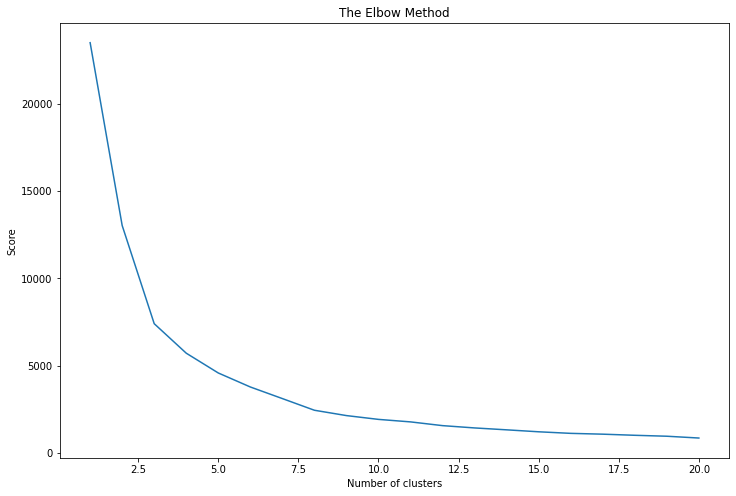

In [13]:
# Get the custom topic modelling class
custom_topic = ctm.HOCCustomTopic()
# Load Cr5 model
model = custom_topic.get_model(PATH)
# Create Cr5 embedding for the data
embedding21 = custom_topic.get_cr5_embeddings(df_head_dt_gp_21, model)
# Reducing the embedding via UMAP
umap_embedding21 = custom_topic.get_umap_embeddings(embedding21)

k_clusters = 20
# Plot the KMeans clusters via Elbow method
custom_topic.plot_elbow(umap_embedding21, k_clusters)

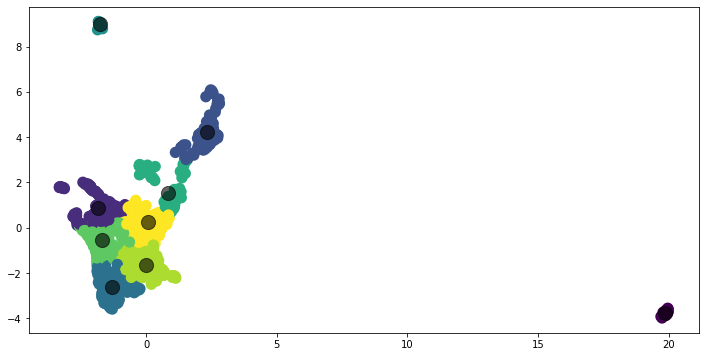

In [14]:
k_clusters = 9
clusters = custom_topic.kmeans_model(umap_embedding21, k_clusters)
# Plot the KMeans clusters PCA
custom_topic.plot_pca(umap_embedding21, k_clusters)

In [15]:
# Get the dataframe of the clusters
docs_per_topic = custom_topic.create_cluster_df(df_head_dt_gp_21, clusters)
# Create tf-idf matrix for the clusters
tf_idf, count = custom_topic.c_tf_idf(docs_per_topic.speech_processed.values, m=len(df_head_dt_gp_21))

# Get top n words for each cluster
top_n_words = custom_topic.extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = custom_topic.extract_topic_sizes(df_head_dt_gp_21)

# Remove the procedural speeches in the dataframe after analysing the topics 
removed_speeech = df_head_dt_gp_21[df_head_dt_gp_21.Topic.isin([2])]['speech_processed'].count()
print(f"Removed {removed_speeech} speeches, due to procedural content")
# New dataframe without the procedural speeches
df_head_dt_gp_new = df_head_dt_gp_21[~df_head_dt_gp_21.Topic.isin([2])].reset_index()

# Get the Cr5 embedding for the new dataframe
embedding_nw = custom_topic.get_cr5_embeddings(df_head_dt_gp_new, model)
# Create the UMAP embedding for the new dataframe
umap_embedding_nw = custom_topic.get_umap_embeddings(embedding_nw)

Removed 154 speeches, due to procedural content


In [16]:
k_clusters = 9
# Get the KMeans clusters for the new dataframe
clusters = custom_topic.kmeans_model(umap_embedding_nw, k_clusters)
# Create the dataframe of the clusters
docs_per_topic_nw = custom_topic.create_cluster_df(df_head_dt_gp_new, clusters)

# Get the tf-idf matrix for the new dataframe
tf_idf_nw, count_nw = custom_topic.c_tf_idf(docs_per_topic_nw.speech_processed.values, m=len(df_head_dt_gp_new))

# Get top n words for each cluster
top_n_words_nw = custom_topic.extract_top_n_words_per_topic(tf_idf_nw, count_nw, docs_per_topic_nw, n=20)
topic_sizes_nw = custom_topic.extract_topic_sizes(df_head_dt_gp_new)

In [17]:
# Print the topics in the dataframe
for i in range(len(top_n_words_nw)):
    print(f"Topic {i}: {top_n_words_nw[i][:5]}")
    print("********")

Topic 0: [('divorce', 0.00042941899006774105), ('forensic', 0.0004158501766059385), ('probation', 0.0004147926123209701), ('holocaust', 0.0004005025257598626), ('grenfell', 0.0003999637493718524)]
********
Topic 1: [('duke', 0.007238993576507867), ('prince', 0.006905596333339264), ('philip', 0.006524381457876186), ('highness', 0.0058072042756650444), ('queen', 0.004391620843775675)]
********
Topic 2: [('object', 0.39495849642474534), ('friday', 0.04354372537812976), ('november', 0.024261165845788447), ('resumed', 0.021629117281030317), ('october', 0.017278106786772177)]
********
Topic 3: [('proxy', 0.0809196089723531), ('certified', 0.06528076181700031), ('nominated', 0.06491330468659567), ('ayes', 0.06261042936512885), ('divided', 0.05763943005457699)]
********
Topic 4: [('aria', 0.0003542301653914321), ('cooperative', 0.0003361737211119133), ('selfemployment', 0.00033469740907051955), ('kickstart', 0.0003290176688230413), ('freelancer', 0.00032639457863967137)]
********
Topic 5: [('p

#### Semantic Similarity
+ We will calculate for the semantic similarity of the speeches based on the Document Embedding via Cr5 Model

In [4]:
# Load the class
semantic_similar = ss.HOCSemanticSimilarity(df_head_dt_gp_21, df_head_dt_gp_20)
# Load the model
model = semantic_similar.get_model(PATH)

# Get the common heading for 2021 and 2020
common_heading = list(set(df_head_dt_gp_21.major_heading) & set(df_head_dt_gp_20.major_heading))
# Get he similarity score for the common heading
similarity, median_dict = semantic_similar.get_similarity_data(common_heading, model)

# Find the top and the bottom 5 semantic score for the common heading
top_5 = dict(sorted(median_dict.items(), key=operator.itemgetter(1), reverse=True)[:5])
last_5  = dict(sorted(median_dict.items(), key=operator.itemgetter(1), reverse=False)[:5])

df_violin = semantic_similar.create_df(np.array(similarity), common_heading)
# Get the dataframe of the top and the bottom 5 semantic score
top_semantic_change = df_violin[df_violin['Heading'].isin(list(top_5.keys()))]
least_semantic_change = df_violin[df_violin['Heading'].isin(list(last_5.keys()))]

C:\Users\joshi\AppData\Local\Temp\ipykernel_12112\2798562581.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_violin = semantic_similar.create_df(np.array(similarity), common_heading)


In [5]:
print(top_5)
print(last_5)

{'Covid-19: Repatriation of UK Nationals': 0.9999999999999998, 'Committees': 0.9604768019896839, 'International Women’s Day': 0.9404295366212306, 'Income Tax (Charge)': 0.937681403332207, 'Education (Guidance about Costs of School Uniforms) Bill': 0.9179073170215322}
{'Bill Presented': 0.0069111330460063505, 'Deputy Speaker’s Statement': 0.11283346876214272, 'Prayers - [Mr Speaker in the Chair]': 0.11729135880453982, 'Speaker’s Statement': 0.1298339202936385, 'Personal Statement': 0.1314972214258499}


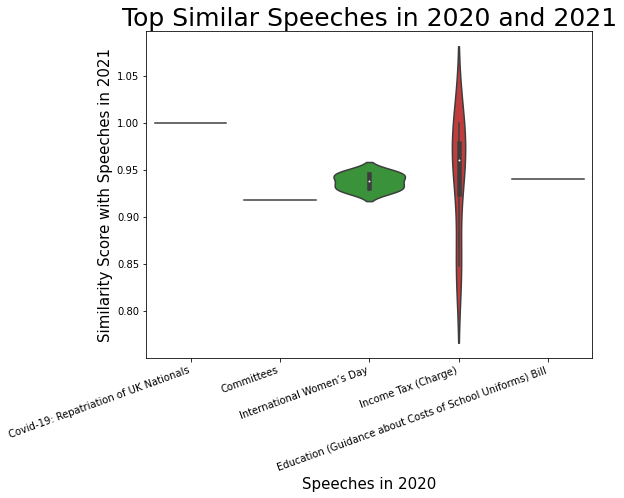

In [6]:
# Plot the voilin plot for the top 5 semantic score
semantic_similar.plot_similarity_data(top_semantic_change, top_5,'top_semantic_change')

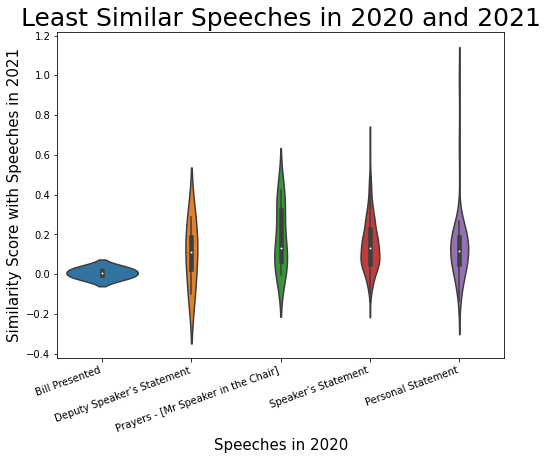

In [7]:
# Plot the voilin plot for the last 5 semantic score
semantic_similar.plot_similarity_data(least_semantic_change, last_5,'least_semantic_change')

#### Word2Vec-Orthogonal Prosecutes

In [9]:
# Fetch class for word2vec model
w2v = w2vop.HOCw2v()
# Creating tokens for the covid speech dataset
df_covid_20 = w2v.tokenize(df_covid_20)
df_covid_21 = w2v.tokenize(df_covid_21)

## Word2Vec model for covid speeches in two different time spans
model21 = w2v.word2vec_model(df_covid_21['speech_tokens'].tolist())
model20 = w2v.word2vec_model(df_covid_20['speech_tokens'].tolist())

ortho_pros = w2vop.HOCOrthoPros()

"""Aligning the two models"""
ortho_pros.smart_procrustes_align_gensim(model21, model20, words=None)

print(f"The two model are alligned") if model21.wv.index_to_key == model20.wv.index_to_key else print("Models not alligned")

<string>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


154 154
154 154
The two model are alligned


In [7]:
"""Let's look at the similarity between two words in the two spaces:"""

print(model20.wv.similarity("covid", "school"))
print(model21.wv.similarity("covid", "school"))

0.2925477
0.9792777


In [8]:
"""Calculate the semantic change for all words in the vocabulary, and store this in the 
   dataframe semantic_change; I also add a column for the frequency of the word in the first space and another one for its frequency 
   in the second space:"""

semantic_change_df = pd.DataFrame(([w, ortho_pros.semantic_change(w, model20, model21), model20.wv.get_vecattr(w, "count") , model21.wv.get_vecattr(w, "count") ] for w in model21.wv.index_to_key), columns = ('Word', 'Semantic_change', "Frequency_2020", "Frequency_2021"))
semantic_change_df.head(10)

,Word,Semantic_change,Frequency_2020,Frequency_2021
0,not,0.735125,75,2001
1,people,0.621964,45,1691
2,right,0.751094,40,1200
3,get,0.709065,37,1028
4,friend,0.737107,36,1026
5,secretary,0.873057,32,952
6,state,0.885768,32,884
7,test,0.610378,31,864
8,testing,0.516114,27,843
9,need,0.659850,27,824
